# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [133]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression, RFECV
from sklearn import linear_model
from sklearn import metrics
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 300)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('kc_house_data_train.csv', index_col=0)
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
5,1761300310,20140827T000000,211000.0,4,2.00,1710,8288,1.5,0,0,3,7,1710,0,1970,0,98031,47.3947,-122.174,1710,7200
6,7732410120,20140819T000000,790000.0,4,2.50,2690,8036,2.0,0,0,4,9,2690,0,1987,0,98007,47.6596,-122.144,2420,8087
7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,0,5,7,1350,450,1970,0,98199,47.6599,-122.396,1920,4400
8,291310170,20140804T000000,384500.0,3,2.50,1600,2610,2.0,0,0,3,8,1600,0,2005,0,98027,47.5344,-122.068,1445,1288
9,4232901990,20140516T000000,605000.0,2,1.00,910,3600,1.0,0,0,4,7,910,0,1909,0,98119,47.6341,-122.361,1720,3600


In [3]:
df.shape

(17290, 21)

In [4]:
df.isnull().sum() # Confirming that we have no missing values

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

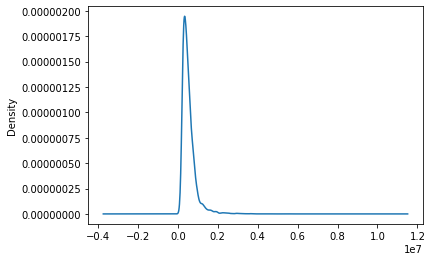

In [5]:
df.price.plot(kind='kde')

In [6]:
df['decade_built'] = df.yr_built.apply(lambda x: (x//10) *10)

In [7]:
df.decade_built.value_counts()

2000    2757
1960    2158
1950    1994
1980    1843
1990    1798
1970    1796
1940    1406
2010     983
1920     966
1910     651
1900     515
1930     423
Name: decade_built, dtype: int64

In [8]:
df['decade_renovated'] = df.yr_renovated.apply(lambda x: (x//10) * 10)

In [9]:
df.decade_renovated.value_counts()

0       16564
2000      223
2010      145
1990      143
1980      118
1970       44
1960       26
1950       17
1940        9
1930        1
Name: decade_renovated, dtype: int64

In [10]:
# df = df[df.bedrooms < 30]

## Step 3: Clean up any issues with the data like extreme values.  

remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout dataset, and you can't just delete those rows and not have a prediction for it. 

In [87]:
continuous_variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
categorical_variables = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'view', 'decade_built', 
                         'decade_renovated']
#leaving out: id, date, price (target), view (was the house viewed), lat, long, zipcode

df_cont = df[continuous_variables]
df_cate = df[categorical_variables]

In [88]:
#Scaling our continuous variables:
scaler = StandardScaler()
scaled_df_cont = pd.DataFrame(scaler.fit_transform(df_cont), columns = continuous_variables)
scaled_df_cont.head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,-0.012462,-0.150116,0.338495,-0.659293,0.587067,-0.190015
1,0.889720,-0.201246,0.049074,1.755299,0.557861,-0.242060
2,1.835381,-0.102838,2.388562,-0.659293,2.514685,-0.117109
3,2.694084,-0.015020,3.341240,-0.659293,3.011193,0.049676
4,0.509282,-0.233253,0.917338,-0.659293,0.382622,-0.324075


In [89]:
def to_category_dtype(dataframe):
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].astype('category')
    return dataframe

In [90]:
df_cate = to_category_dtype(df_cate)

In [91]:
df_cate['bedrooms'].value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
33       1
11       1
Name: bedrooms, dtype: int64

In [92]:
# Dummy our categorical variables:
dummy_df_cate = pd.get_dummies(df_cate, drop_first=True)
dummy_df_cate.head()

,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,decade_built_1910,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,decade_renovated_1930,decade_renovated_1940,decade_renovated_1950,decade_renovated_1960,decade_renovated_1970,decade_renovated_1980,decade_renovated_1990,decade_renovated_2000,decade_renovated_2010
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [93]:
dummy_df_cate.shape # Without changing yr to decade, had 250 features.

(17290, 86)

In [94]:
# To reduce columns: clean bedrooms DONE, limit bathrooms to 5+, yr_built to decade_built DONE, yr_reno to decade_reno DONE

In [95]:
df_all_feats = pd.concat([scaled_df_cont, dummy_df_cate], axis=1)
df_all_feats.shape

(17290, 92)

In [96]:
df_all_feats.head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,decade_built_1910,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010,decade_renovated_1930,decade_renovated_1940,decade_renovated_1950,decade_renovated_1960,decade_renovated_1970,decade_renovated_1980,decade_renovated_1990,decade_renovated_2000,decade_renovated_2010
0,-0.012462,-0.150116,0.338495,-0.659293,0.587067,-0.190015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.889720,-0.201246,0.049074,1.755299,0.557861,-0.242060,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.835381,-0.102838,2.388562,-0.659293,2.514685,-0.117109,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2.694084,-0.015020,3.341240,-0.659293,3.011193,0.049676,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.509282,-0.233253,0.917338,-0.659293,0.382622,-0.324075,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Step 4: Generate new features that you think could be important

After doing this, you will want to go back to steps 2 and 3 to investigates these new features

### 4.1) Identify a categorical variable in the data set and create dummy columns.

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column

In [97]:
#conditions = [
#     df.yr_renovated == False,
#     df.yr_renovated == True
# ]

# choices = [
#     df.yr_built,
#     df.yr_renovated - df.yr_built
# ]

In [98]:
# df['last_updated'] = np.select(conditions, choices, default = df.yr_built)
# df.last_updated.value_counts()

In [99]:
# df.last_updated.plot(kind='hist')

### Non-linear transformations

### 4.4) Create a polynomial feature for two of your continuous variables


In [100]:
# your code here

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable) 

In [101]:
# your code here

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

### 5.1) Perform a train test split of the data.

In [102]:
x_train, x_test, y_train, y_test = train_test_split(df_all_feats, df['price'], random_state=20)#check the shape of the results
print("Training set - Features: ", x_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", x_test.shape, "Target: ",y_test.shape)

Training set - Features:  (12967, 92) Target:  (12967,)
Training set - Features:  (4323, 92) Target:  (4323,)


### 5.2) Fit your scaler to training the data.

In [103]:
#instantiate a linear regression object
model = linear_model.LinearRegression()

#fit the linear regression to the data
model = model.fit(x_train, y_train)


print(model.intercept_)
print(model.coef_)

561461.0276358414
[ 5.67200767e+04  6.67575592e+02  4.26991474e+04  3.78529575e+04
  3.70778765e+04 -1.09014911e+04 -3.33266834e+04 -1.57080264e+04
 -4.41329824e+04 -7.04478438e+04 -7.56627216e+04 -1.07943779e+05
 -2.33847616e+05  1.12080846e+05 -3.49762711e+05 -3.39867735e+05
 -3.08645254e+05  7.13807491e+04  2.74080291e+03  5.29190701e+03
  7.99278217e+04  4.74459718e+04  8.84801131e+04  8.70756027e+04
  8.94257466e+04  1.08932324e+05  8.33818708e+04  8.08563757e+04
  1.19948660e+05  1.61015760e+05  1.29015374e+05  2.59473389e+05
  2.47096328e+05  2.37095528e+05  2.39514045e+05  5.58865689e+05
  5.13586250e+05  7.74936906e+05  7.59718537e+05  1.19566290e+06
  4.54622565e+05  6.15215725e+05  4.36557457e-09  2.52219041e+05
  3.17046213e+05  3.71548890e+06  2.43890099e-08 -2.20487662e+03
  2.13039524e+04  1.52402913e+05  1.11266463e+05  2.87752644e+05
  5.83468920e+05  1.01673980e+05  1.09487014e+05  1.35794473e+05
  1.90674294e+05 -1.85805513e+05 -2.29420321e+05 -2.70102857e+05
 -2.078

In [104]:
print ("R^2 Score:", model.score(x_train, y_train))

R^2 Score: 0.711292823515475


In [105]:
y_train_pred = model.predict(x_train)

In [106]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 131419.67444591975
Mean Squared Error: 40869606767.09205
Root Mean Squared Error: 202162.32776432915


### 5.5) Use the model to predict on the training set and the test set.

In [107]:
y_pred = model.predict(x_test)

In [108]:
print ("Score:", model.score(x_test, y_test))

Score: 0.6810451667156521


### 5.6) Evaluate the training and test predictions using RMSE.

In [109]:
test_mae = metrics.mean_absolute_error(y_test, y_pred)            # Calculate MAE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))   # Calculate RMSE

print('Mean Absolute Error: ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: ' + str(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Mean Absolute Error: 132113.0368967863
Mean Squared Error: 42325745410.20033
Root Mean Squared Error: 205732.21772537314


### 5.7) Determine if your model is overfit.

In [110]:
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse)) 

Training:  202162 vs. Testing:  205732


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [111]:
selector = SelectKBest(f_regression, k=20)

selector.fit(x_train, y_train)
selected_columns = x_train.columns[selector.get_support()]
removed_columns = x_train.columns[~selector.get_support()]

In [112]:
#list(removed_columns)

In [113]:
list(selected_columns)

['sqft_living',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bathrooms_1.0',
 'bathrooms_3.25',
 'bathrooms_3.5',
 'floors_2.0',
 'waterfront_1',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'view_4']

### 6.2) After removing the features, rerun steps 5 and see if you r new model performs better than the old model.

In [114]:
#instantiate a linear regression object
kbest_model = linear_model.LinearRegression()

#fit the linear regression to the data
kbest_model = kbest_model.fit(x_train[selected_columns], y_train)

y_train_kbest = kbest_model.predict(x_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = kbest_model.predict(x_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('Testing Root Mean Squared Error:' , testK_rmse)

print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 225023.15579687312
Testing Root Mean Squared Error: 221037.01848823563
Original:  205732.21772537314 vs. KBest:  221037.01848823563


## Step 7: Evaluate your different models in order to determine the best model overall

In [115]:
recursive_model = linear_model.LinearRegression()

# Create recursive feature eliminator that scores features by mean squared errors
recursive_selector = RFECV(estimator=recursive_model, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
recursive_selector.fit(x_train, y_train)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [116]:
selected_rfe = x_train.columns[recursive_selector.support_]
removed_rfe = x_train.columns[~recursive_selector.support_]

In [117]:
list(removed_rfe)

['sqft_lot', 'bathrooms_0.5', 'bathrooms_6.5', 'bathrooms_8.0', 'floors_1.5']

In [118]:
len(list(selected_rfe))

87

In [119]:
#instantiate a linear regression object
lm_rfe = linear_model.LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(x_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(x_train[selected_rfe])
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(x_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
print('Testing Root Mean Squared Error:' , testRFE_rmse)

print('Original: ', test_rmse, "vs. KBest: ", testK_rmse, "vs. RFE: ", testRFE_rmse)

Training Root Mean Squared Error: 202163.6210242695
Testing Root Mean Squared Error: 205714.68334066868
Original:  205732.21772537314 vs. KBest:  221037.01848823563 vs. RFE:  205714.68334066868


## Adding Polynomial Features

In [120]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df_all_feats[selected_columns]) # Best Columns from KBest Above
poly_columns = poly.get_feature_names(df_all_feats.columns)
df_poly_all_feats = pd.DataFrame(poly_data, columns=poly_columns)
df_poly_all_feats = df_poly_all_feats.drop('bedrooms_33', axis=1)

In [121]:
x_poly_train, x_poly_test, y_poly_train, y_poly_test = train_test_split(df_poly_all_feats, df['price'], random_state=20)#check the shape of the results
print("Training set - Features: ", x_poly_train.shape, "Target: ", y_poly_train.shape)
print("Training set - Features: ", x_poly_test.shape, "Target: ",y_poly_test.shape)

Training set - Features:  (12967, 229) Target:  (12967,)
Training set - Features:  (4323, 229) Target:  (4323,)


In [122]:
# instantiate a linear regression object
poly_model = linear_model.LinearRegression()

#fit the linear regression to the data
poly_model = poly_model.fit(x_poly_train, y_poly_train)

y_poly_train_pred = poly_model.predict(x_poly_train)

poly_train_rmse = np.sqrt(metrics.mean_squared_error(y_poly_train, y_poly_train_pred))


print('Training Root Mean Squared Error:' , poly_train_rmse)

Training Root Mean Squared Error: 203338.48618128395


In [123]:
# use fitted model to predict on test data
y_poly_pred = poly_model.predict(x_poly_test)

poly_test_rmse = np.sqrt(metrics.mean_squared_error(y_poly_test, y_poly_pred))
print('Testing Root Mean Squared Error:' , poly_test_rmse)

print('Training: ', int(poly_train_rmse), "vs. Testing: ", int(poly_test_rmse))

Testing Root Mean Squared Error: 586268633745.7356
Training:  203338 vs. Testing:  586268633745


### Removing Correlated Features

In [124]:
# Create correlation matrix
corr_matrix = x_poly_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [125]:
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

#if you change inplace to True it will go through and drop all of those columns from the dataset
x_poly_train.drop(columns=to_drop, inplace=True)
x_poly_test.drop(columns=to_drop, inplace=True)

In [126]:
# instantiate a linear regression object
poly_model_drop = linear_model.LinearRegression()

#fit the linear regression to the data
poly_model_drop = poly_model_drop.fit(x_poly_train, y_poly_train)

y_poly_train_pred = poly_model_drop.predict(x_poly_train)

poly_train_rmse = np.sqrt(metrics.mean_squared_error(y_poly_train, y_poly_train_pred))


print('Training Root Mean Squared Error:' , poly_train_rmse)

Training Root Mean Squared Error: 203907.90721222857


### LASSO

In [127]:
x_poly_train.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'bedrooms_1', 'bedrooms_2', 'bedrooms_3',
       'bedrooms_4',
       ...
       'bedrooms_10 bedrooms_11', 'bedrooms_10 bedrooms_33',
       'bedrooms_10 bathrooms_0.5', 'bedrooms_10 bathrooms_0.75',
       'bedrooms_11 bedrooms_33', 'bedrooms_11 bathrooms_0.5',
       'bedrooms_11 bathrooms_0.75', 'bedrooms_33 bathrooms_0.5',
       'bedrooms_33 bathrooms_0.75', 'bathrooms_0.5 bathrooms_0.75'],
      dtype='object', length=191)

In [132]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.05, normalize=True)

lasso.fit(x_poly_train,y_poly_train)

y_lasso_train_pred = lasso.predict(x_poly_train)
y_lasso_pred = lasso.predict(x_poly_test)

train_rmse = metrics.mean_absolute_error(y_poly_train, y_lasso_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_poly_test, y_lasso_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 139278.91641789145
Testing Error: 247376.57879005634


In [140]:
x_total = pd.concat([x_poly_test, x_poly_train], ignore_index=True)
y_total = pd.concat([y_poly_test, y_poly_train], ignore_index=True)

## Step 8:  Refit your best model to the entire dataset

In [146]:
final_model = lasso.fit(x_total, y_total)

## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [147]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_total,y_total)
print(result)

0.6957939642622689
